In [2]:
import pandas as pd
import numpy as np
from pulp import *
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from math import sqrt

from keras.models import Sequential
from keras.layers import LSTM, Dropout
from keras.layers import Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error

from keras import backend as K

Using TensorFlow backend.


In [3]:
# array stacking
def create_sequence(df, cols, time_indexes, target):
  seqs = []
  for col in cols:
    seq = df[col].values.reshape((len(df[col]), 1))
    seqs.append(seq)
  for index in time_indexes:
    seq = index.values.reshape((len(df[col]), 1))
    seqs.append(seq)
  seq = df[target].values.reshape((len(df[target]), 1))
  for i in range(len(seq)):
    if seq[i] < 0:
      seq[i] = 0
  seqs.append(seq)
  dataset = np.hstack((seqs))  
  return dataset

def split_sequence_multi(sequence, n_steps, n_steps_out):
  X, y = list(), list()
  for i in range(len(sequence)):
    end_ix = i + n_steps
    out_ix = end_ix + n_steps_out
    # boundary check
    if out_ix > len(sequence):
      break
    seq_x, seq_y = sequence[i:end_ix, :], sequence[end_ix:out_ix, -1]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

# https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error
def sMAPE(y_true, y_pred):
    #Symmetric mean absolute percentage error
    return 100 * K.mean(K.abs(y_pred - y_true) / (K.abs(y_pred) + K.abs(y_true)), axis=-1)

## Solar power forecasting

In [4]:
df = pd.read_csv('../LSTM-power-forecasting/pvdaq_2012_2014_hourly.csv', header=0, infer_datetime_format=True, parse_dates=['Date-Time'], index_col=['Date-Time'])

In [5]:
# columns to use for forecasting
cols = ['ambient_temp', 'inverter_temp', 'module_temp', 'poa_irradiance', 
        'relative_humidity', 'wind_direction', 'wind_speed']
time_indexes = [df.index.hour, df.index.month]
# we will forecast dc power output
target = ['dc_power']

In [6]:
dataset = (create_sequence(df, cols, time_indexes, target))
X, y = split_sequence_multi(dataset, 12, 6)
print(X.shape, y.shape)

(26287, 12, 10) (26287, 6)


In [7]:
# n_steps is amount of time steps per sample
# n_steps_out is the amount of time steps model has to forecast
n_steps, n_steps_out = 24, 6
# number of features in each timestep
n_features=X.shape[2]
X, y = split_sequence_multi(dataset, n_steps, n_steps_out)
train_X, train_y = X[:-2000,:], y[:-2000,:]
val_X, val_y = X[-2000:-1000,:], y[-2000:-1000,:]
test_X, test_y = X[-1000:,:], y[-1000:,:]

model = Sequential()
model.add(LSTM(300, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(200, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mae')

model.fit(train_X, train_y, batch_size=32, epochs = 20, validation_data=(val_X, val_y))
# A stateful recurrent model is one for which the internal states (memories) 
# obtained after processing a batch of samples are reused as initial states for the samples of the next batch

predictions = model.predict(test_X)

predictions1 = model.predict(train_X)
mse = mean_squared_error(train_y, predictions1)
rmse = sqrt(mse)
mae = mean_absolute_error(train_y, predictions1)
#mape = mean_absolute_percentage_error(predictions1, test_y)
print('MSE:',round(mse),'RMSE:', round(rmse),'MAE:', round(mae))

test_seq1 = []
pred_seq1 = []
for i in range(36):
  test_seq1 = np.concatenate((test_seq1, test_y[i*6]))
  pred_seq1 = np.concatenate((pred_seq1, predictions[i*6]))

Train on 24275 samples, validate on 1000 samples
Epoch 1/20
24275/24275 [==============================] - 119s 5ms/step - loss: 6469.0540 - val_loss: 3511.5691
Epoch 2/20
24275/24275 [==============================] - 101s 4ms/step - loss: 5946.4677 - val_loss: 7239.7193
Epoch 3/20
24275/24275 [==============================] - 108s 4ms/step - loss: 5170.4281 - val_loss: 4103.7697
Epoch 4/20
24275/24275 [==============================] - 106s 4ms/step - loss: 3950.1984 - val_loss: 2507.0503
Epoch 5/20
24275/24275 [==============================] - 108s 4ms/step - loss: 3247.4308 - val_loss: 2511.3015
Epoch 6/20
24275/24275 [==============================] - 108s 4ms/step - loss: 3546.3721 - val_loss: 3544.7872
Epoch 7/20
24275/24275 [==============================] - 107s 4ms/step - loss: 3001.1543 - val_loss: 2068.3499
Epoch 8/20
24275/24275 [==============================] - 107s 4ms/step - loss: 2700.5182 - val_loss: 1656.2538
Epoch 9/20
24275/24275 [==============================]

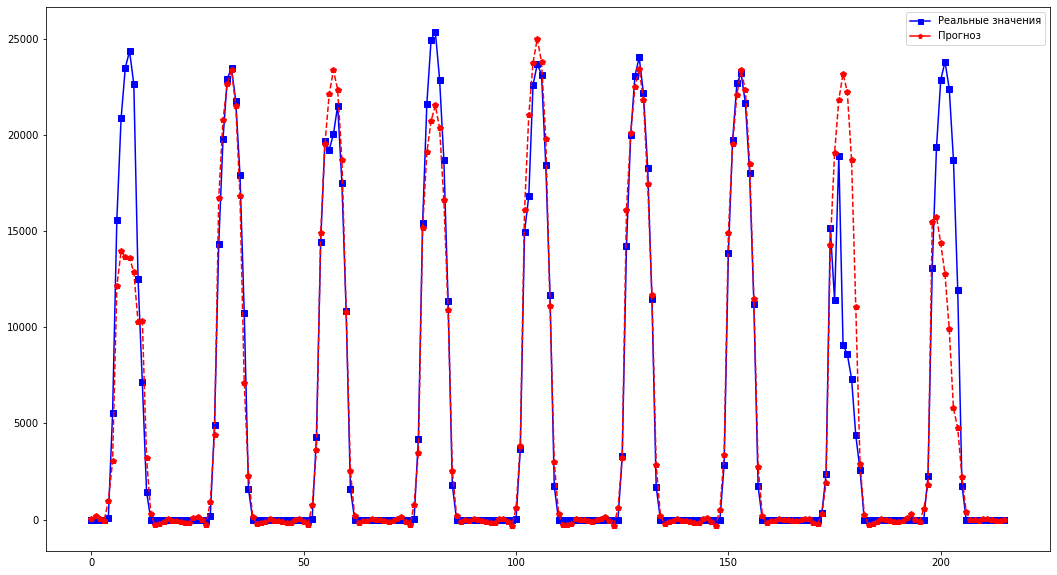

In [8]:
blue_line = mlines.Line2D([], [], color='blue', marker='s',
                          markersize=5, label='Реальные значения')
red_line = mlines.Line2D([], [], color='red', marker='p',
                          markersize=5, label='Прогноз')

#plt.legend(handles=[blue_line, red_line])


plt.figure(figsize=(18,10))
plt.plot(test_seq1, 'b-s')
plt.plot(pred_seq1, 'r--p')
plt.legend(handles=[blue_line, red_line])

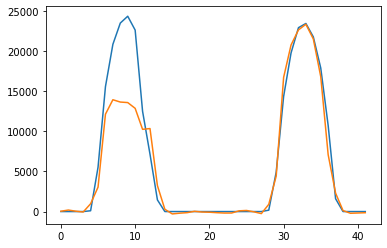

In [9]:
test_seq = np.concatenate((test_y[0], test_y[6], test_y[12], test_y[18], test_y[24], test_y[30], test_y[36]))
pred_seq = np.concatenate((predictions[0], predictions[6], predictions[12], predictions[18], predictions[24], predictions[30], predictions[36]))
plt.plot(test_seq)
plt.plot(pred_seq)

In [10]:
solar_preds = pred_seq1

## Power consumption forecasting

In [11]:
house_df = pd.read_csv('datasets/KAG_energydata_complete.csv', header=0, infer_datetime_format=True, parse_dates=['date'], index_col=['date'])

In [12]:
house_df.head(20)

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,45.566667,...,17.033333,45.530000,6.600000,733.500000,92.000000,7.000000,63.000000,5.300000,13.275433,13.275433
2016-01-11 17:10:00,60,30,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,45.992500,...,17.066667,45.560000,6.483333,733.600000,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195
2016-01-11 17:20:00,50,30,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,45.890000,...,17.000000,45.500000,6.366667,733.700000,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668
2016-01-11 17:30:00,50,40,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,45.723333,...,17.000000,45.400000,6.250000,733.800000,92.000000,6.000000,51.500000,5.000000,45.410389,45.410389
2016-01-11 17:40:00,60,40,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,45.530000,...,17.000000,45.400000,6.133333,733.900000,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097
2016-01-11 17:50:00,50,40,19.890000,46.026667,19.200000,44.500000,19.790000,44.933333,18.890000,45.730000,...,17.000000,45.290000,6.016667,734.000000,92.000000,5.333333,43.833333,4.800000,44.919484,44.919484
2016-01-11 18:00:00,60,50,19.890000,45.766667,19.200000,44.500000,19.790000,44.900000,18.890000,45.790000,...,17.000000,45.290000,5.900000,734.100000,92.000000,5.000000,40.000000,4.700000,47.233763,47.233763
2016-01-11 18:10:00,60,50,19.856667,45.560000,19.200000,44.500000,19.730000,44.900000,18.890000,45.863333,...,17.000000,45.290000,5.916667,734.166667,91.833333,5.166667,40.000000,4.683333,33.039890,33.039890
2016-01-11 18:20:00,60,40,19.790000,45.597500,19.200000,44.433333,19.730000,44.790000,18.890000,45.790000,...,17.000000,45.290000,5.933333,734.233333,91.666667,5.333333,40.000000,4.666667,31.455702,31.455702


In [13]:
house_df['consumption'] = house_df['Appliances'] + house_df['lights']
# resampling dataframe to hourly format to match everything
#resampled_wind_df = wind_df.resample('1H').median().drop(['consumption', 'Appliances', 'lights'], axis=1)
#resampled_wind_df['consumption'] = wind_df.resample('1H').sum()['consumption']
#wind_df = resampled_wind_df

cols = ['T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9']
target = ['consumption']
time_indexes = [house_df.index.hour, house_df.index.dayofweek, house_df.index.month]
house_dataset = create_sequence(house_df, cols, time_indexes, target)

In [14]:
# n_steps is amount of time steps per sample
# n_steps_out is the amount of time steps model has to forecast
n_steps, n_steps_out = 24, 6
# number of features in each timestep
X, y = split_sequence_multi(house_dataset, n_steps, n_steps_out)
n_features=X.shape[2]
train_X, train_y = X[:14000,:], y[:14000,:]
val_X, val_y = X[14000:16000,:], y[14000:16000,:]
test_X, test_y = X[16000:,:], y[16000:,:]

#train_X, train_y = X[:2000,:], y[:2000,:]
#val_X, val_y = X[2000:2600,:], y[2000:2600,:]
#test_X, test_y = X[2600:,:], y[2600:,:]

print('train:', len(train_X), 'val:', len(val_X), 'test:', len(test_X))


model = Sequential()
model.add(LSTM(350, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(250, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

model.fit(train_X, train_y, batch_size=16, epochs = 20, validation_data=(val_X, val_y))
# A stateful recurrent model is one for which the internal states (memories) 
# obtained after processing a batch of samples are reused as initial states for the samples of the next batch

predictions = model.predict(test_X)

predictions1 = model.predict(train_X)
mse = mean_squared_error(train_y, predictions1)
rmse = sqrt(mse)
mae = mean_absolute_error(train_y, predictions1)
#mape = mean_absolute_percentage_error(predictions1, test_y)
print('MSE:',round(mse),'RMSE:', round(rmse),'MAE:', round(mae))



train: 14000 val: 2000 test: 3706
Train on 14000 samples, validate on 2000 samples
Epoch 1/20
14000/14000 [==============================] - 111s 8ms/step - loss: 279800.2567 - val_loss: 14992.5759
Epoch 2/20
14000/14000 [==============================] - 109s 8ms/step - loss: 15033.9046 - val_loss: 12705.1626
Epoch 3/20
14000/14000 [==============================] - 109s 8ms/step - loss: 14442.8267 - val_loss: 12486.0909
Epoch 4/20
14000/14000 [==============================] - 110s 8ms/step - loss: 17785.4662 - val_loss: 10605.9183
Epoch 5/20
14000/14000 [==============================] - 111s 8ms/step - loss: 13315.0253 - val_loss: 10933.1598
Epoch 6/20
14000/14000 [==============================] - 110s 8ms/step - loss: 12888.0222 - val_loss: 14382.6068
Epoch 7/20
14000/14000 [==============================] - 110s 8ms/step - loss: 12806.1289 - val_loss: 10211.0464
Epoch 8/20
14000/14000 [==============================] - 110s 8ms/step - loss: 12987.2669 - val_loss: 11667.2124
Epoc

In [15]:
house_test_seq1 = []
house_pred_seq1 = []
for i in range(216):
  house_test_seq1 = np.concatenate((house_test_seq1, test_y[i*6]))
  house_pred_seq1 = np.concatenate((house_pred_seq1, predictions[i*6]))

# resampling into hourly format
house_test_seq = []
for i in range(len(house_test_seq1)//6):
    house_test_seq.append(house_test_seq1[6*i:6*i+6].sum())

house_pred_seq = []
for i in range(len(house_pred_seq1)//6):
    house_pred_seq.append(house_pred_seq1[6*i+12:6*i+18].sum())

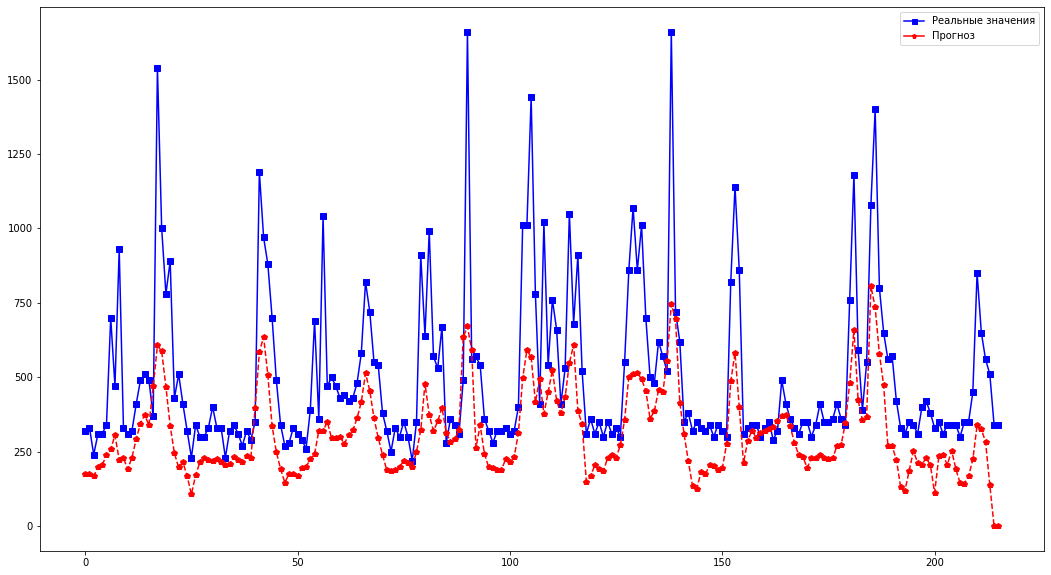

In [16]:
blue_line = mlines.Line2D([], [], color='blue', marker='s',
                          markersize=5, label='Реальные значения')
red_line = mlines.Line2D([], [], color='red', marker='p',
                          markersize=5, label='Прогноз')

#plt.legend(handles=[blue_line, red_line])


plt.figure(figsize=(18,10))
plt.plot(house_test_seq, 'b-s')
plt.plot(house_pred_seq, 'r--p')
plt.legend(handles=[blue_line, red_line])

In [17]:
house_preds = house_pred_seq

## Wind power forecasting

In [18]:
wind_df = pd.read_csv('datasets/T1.csv', header=0, infer_datetime_format=True, parse_dates=['Date/Time'], index_col=['Date/Time'])

In [19]:
wind_df

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
Date/Time,,,,
2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904
2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113
2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789
2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087
2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286
...,...,...,...,...
2018-12-31 23:10:00,2963.980957,11.404030,3397.190793,80.502724
2018-12-31 23:20:00,1684.353027,7.332648,1173.055771,84.062599
2018-12-31 23:30:00,2201.106934,8.435358,1788.284755,84.742500


In [20]:
cols = ['Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)']
target = ['LV ActivePower (kW)']
time_indexes = [wind_df.index.hour, wind_df.index.month]
wind_dataset = create_sequence(wind_df, cols, time_indexes, target)


In [21]:
# n_steps is amount of time steps per sample
# n_steps_out is the amount of time steps model has to forecast
n_steps, n_steps_out = 24, 6
# number of features in each timestep
X, y = split_sequence_multi(wind_dataset, n_steps, n_steps_out)
n_features=X.shape[2]
train_X, train_y = X[:30000,:], y[:30000,:]
val_X, val_y = X[30000:40000,:], y[30000:40000,:]
test_X, test_y = X[40000:,:], y[40000:,:]

#train_X, train_y = X[:2000,:], y[:2000,:]
#val_X, val_y = X[2000:2600,:], y[2000:2600,:]
#test_X, test_y = X[2600:,:], y[2600:,:]

print('train:', len(train_X), 'val:', len(val_X), 'test:', len(test_X))


model = Sequential()
model.add(LSTM(300, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(200, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mae')

model.fit(train_X, train_y, batch_size=32, epochs = 14, validation_data=(val_X, val_y))
# A stateful recurrent model is one for which the internal states (memories) 
# obtained after processing a batch of samples are reused as initial states for the samples of the next batch

predictions = model.predict(test_X)

predictions1 = model.predict(train_X)
mse = mean_squared_error(train_y, predictions1)
rmse = sqrt(mse)
mae = mean_absolute_error(train_y, predictions1)
#mape = mean_absolute_percentage_error(predictions1, test_y)
print('MSE:',round(mse),'RMSE:', round(rmse),'MAE:', round(mae))



train: 30000 val: 10000 test: 10501
Train on 30000 samples, validate on 10000 samples
Epoch 1/14
30000/30000 [==============================] - 141s 5ms/step - loss: 2169.4620 - val_loss: 656.6101
Epoch 2/14
30000/30000 [==============================] - 138s 5ms/step - loss: 742.0532 - val_loss: 11481.2747
Epoch 3/14
30000/30000 [==============================] - 141s 5ms/step - loss: 710.4069 - val_loss: 591.7379
Epoch 4/14
30000/30000 [==============================] - 140s 5ms/step - loss: 582.0307 - val_loss: 590.7249
Epoch 5/14
30000/30000 [==============================] - 140s 5ms/step - loss: 524.3775 - val_loss: 568.3880
Epoch 6/14
30000/30000 [==============================] - 141s 5ms/step - loss: 527.4019 - val_loss: 682.7308
Epoch 7/14
30000/30000 [==============================] - 141s 5ms/step - loss: 572.4125 - val_loss: 723.0330
Epoch 8/14
30000/30000 [==============================] - 142s 5ms/step - loss: 621.7904 - val_loss: 662.8541
Epoch 9/14
30000/30000 [=======

In [22]:
predictions1 = model.predict(test_X)
mse = mean_squared_error(test_y, predictions)
rmse = sqrt(mse)
mae = mean_absolute_error(test_y, predictions)
print('MSE:',round(mse),'RMSE:', round(rmse),'MAE:', round(mae))

MSE: 1111687.0 RMSE: 1054 MAE: 738.0


In [23]:
wind_test_seq1 = []
wind_pred_seq1 = []

for i in range(216):
  wind_test_seq1 = np.concatenate((wind_test_seq1, test_y[i*6]))
  wind_pred_seq1 = np.concatenate((wind_pred_seq1, predictions[i*6]))

wind_test_seq = []
for i in range(len(wind_test_seq1)//6):
    wind_test_seq.append(wind_test_seq1[6*i:6*i+6].sum())

wind_pred_seq = []
for i in range(len(wind_pred_seq1)//6):
    wind_pred_seq.append(wind_pred_seq1[6*i+12:6*i+18].sum())

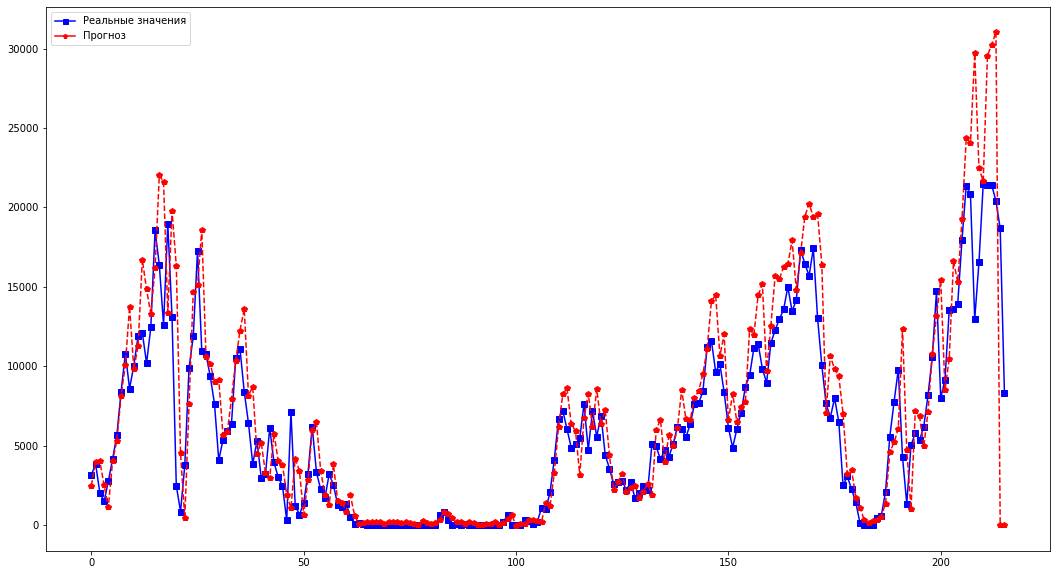

In [24]:
blue_line = mlines.Line2D([], [], color='blue', marker='s',
                          markersize=5, label='Реальные значения')
red_line = mlines.Line2D([], [], color='red', marker='p',
                          markersize=5, label='Прогноз')

#plt.legend(handles=[blue_line, red_line])


plt.figure(figsize=(18,10))
plt.plot(wind_test_seq, 'b-s')
plt.plot(wind_pred_seq, 'r--p')
plt.legend(handles=[blue_line, red_line])

In [25]:
wind_preds = wind_pred_seq

## Power optimization

In [26]:
solar_preds
wind_preds
house_preds

[175.87849617004395,
 173.30123710632324,
 167.25141525268555,
 197.92542266845703,
 204.57182693481445,
 239.7355194091797,
 257.40447998046875,
 305.8494186401367,
 222.6638584136963,
 228.2536735534668,
 191.4931297302246,
 229.86257553100586,
 292.5683479309082,
 343.883846282959,
 373.7570495605469,
 338.6564483642578,
 469.2446594238281,
 606.9062957763672,
 587.15576171875,
 467.6875915527344,
 337.3342971801758,
 244.68390655517578,
 196.88041877746582,
 214.57492065429688,
 167.70286560058594,
 106.58735275268555,
 171.5666961669922,
 214.00487518310547,
 228.4239616394043,
 222.43796920776367,
 218.71048736572266,
 225.14490509033203,
 216.01477813720703,
 204.4756202697754,
 208.86229515075684,
 231.27119064331055,
 222.1391944885254,
 216.8918113708496,
 234.9376220703125,
 229.5970458984375,
 397.30848693847656,
 584.2664031982422,
 635.6421737670898,
 507.4399871826172,
 336.6657371520996,
 248.6230812072754,
 192.0819854736328,
 146.02304458618164,
 176.2246265411377,
 1

In [27]:
house_preds_scaled = [item*10 for item in house_preds]
wind_preds_scaled = [item*2 for item in wind_preds]
solar_preds_scaled = [(0 if x<0 else x) for x in solar_preds]

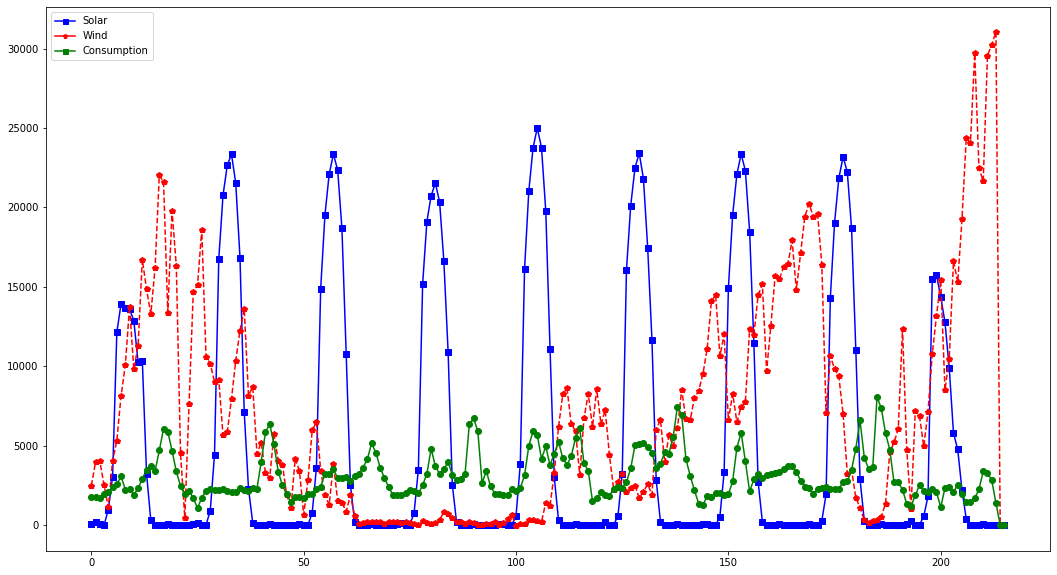

In [28]:
blue_line = mlines.Line2D([], [], color='blue', marker='s',
                          markersize=5, label='Solar')
red_line = mlines.Line2D([], [], color='red', marker='p',
                          markersize=5, label='Wind')
green_line = mlines.Line2D([], [], color='green', marker='s',
                          markersize=5, label='Consumption')
black_line = mlines.Line2D([], [], color='black', marker='p',
                          markersize=5, label='Прогноз')

#plt.legend(handles=[blue_line, red_line])


plt.figure(figsize=(18,10))
plt.plot(solar_preds_scaled, 'b-s')
plt.plot(wind_preds, 'r--p')
plt.plot(house_preds_scaled, 'g-o')
plt.legend(handles=[blue_line, red_line, green_line])

In [29]:
merged_preds = []
for i in range(len(solar_preds)):
    temp_list = [solar_preds_scaled[i], wind_preds[i], house_preds_scaled[i]]
    merged_preds.append(temp_list)

In [30]:
solution_seq = []
storage_value = 0
storage_value_capacity = 18000
for row in merged_preds:
    # row contains maximum possible amount of energy output
    problem = LpProblem("power_optimization", LpMinimize)

    # Prices for energy
    solar_price = 0
    wind_price = 0
    grid_price = 3
    storage_price = 0.1

    # Energy demand
    demand = row[2]

    # Variables
    solar_power = LpVariable('solar_power', 0, row[0])
    wind_power = LpVariable('wind_power', 0, row[1])
    grid_power = LpVariable('grid_power', 0, 10000)
    storage_power = LpVariable('storage_power', 0, storage_value)

    # Constraints
    c1 = solar_power + wind_power + grid_power + storage_power >= demand

    # Objective
    objective = solar_power*solar_price + wind_power*wind_price + grid_power*grid_price + storage_power*storage_price

    # Adding constraints and objectives to problem
    problem += c1
    problem += objective

    #Solving
    #print(problem)
    problem.solve()
    
    # Hacky implementation of power storage
    # Unused solar and wind power goes straight into power storage
    if (value(solar_power)+value(wind_power)>value(demand)):
        storage_value=storage_value + (value(solar_power)+value(wind_power)) - value(demand)
        if storage_value > storage_value_capacity:
            storage_value=storage_value_capacity
        print(storage_value)
    else:
        storage_value = storage_value - value(storage_power)

    # Print solution
    for i in [solar_power, wind_power, grid_power, storage_power, objective]:
        print(i,"=" ,value(i))
    

        
    temp_seq = [value(demand), value(solar_power), value(wind_power), value(grid_power), value(storage_power), storage_value, value(objective)]
    solution_seq.append(temp_seq)
    
results = pd.DataFrame(solution_seq, columns=['Demand', 'Solar', 'Wind', 'Grid', 'Storage', 'Stored Energy', 'Objective'])

757.2105212995602
solar_power = 40.866283
wind_power = 2475.1292
grid_power = 0.0
storage_power = 0.0
3*grid_power + 0.1*storage_power = 0.0
3177.665850236328
solar_power = 187.5119
wind_power = 3965.9558
grid_power = 0.0
storage_power = 0.0
3*grid_power + 0.1*storage_power = 0.0
5555.703442709473
solar_power = 44.971245
wind_power = 4005.5805
grid_power = 0.0
storage_power = 0.0
3*grid_power + 0.1*storage_power = 0.0
6072.5439160249025
solar_power = 0.0
wind_power = 2496.0947
grid_power = 0.0
storage_power = 0.0
3*grid_power + 0.1*storage_power = 0.0
6115.049706676758
solar_power = 973.15656
wind_power = 1115.0675
grid_power = 0.0
storage_power = 0.0
3*grid_power + 0.1*storage_power = 0.0
10793.646212584961
solar_power = 3041.2451
wind_power = 4034.7066
grid_power = 0.0
storage_power = 0.0
3*grid_power + 0.1*storage_power = 0.0
18000
solar_power = 12138.478
wind_power = 5312.49
grid_power = 0.0
storage_power = 0.0
3*grid_power + 0.1*storage_power = 0.0
18000
solar_power = 13940.765
wi

solar_power = 0.0
wind_power = 64.139438
grid_power = 2897.5731
storage_power = 0.0
3*grid_power + 0.1*storage_power = 8692.7193
solar_power = 0.0
wind_power = 214.23438
grid_power = 2181.5219
storage_power = 0.0
3*grid_power + 0.1*storage_power = 6544.565700000001
solar_power = 0.0
wind_power = 190.43667
grid_power = 1687.0696
storage_power = 0.0
3*grid_power + 0.1*storage_power = 5061.2088
solar_power = 38.388012
wind_power = 168.56435
grid_power = 1654.7452
storage_power = 0.0
3*grid_power + 0.1*storage_power = 4964.2356
solar_power = 128.03278
wind_power = 138.86529
grid_power = 1634.0044
storage_power = 0.0
3*grid_power + 0.1*storage_power = 4902.0132
solar_power = 0.0
wind_power = 189.81964
grid_power = 1794.3856
storage_power = 0.0
3*grid_power + 0.1*storage_power = 5383.156800000001
solar_power = 0.0
wind_power = 105.59924
grid_power = 2089.7831
storage_power = 0.0
3*grid_power + 0.1*storage_power = 6269.3493
solar_power = 774.83215
wind_power = 76.082276
grid_power = 1265.1075

18000
solar_power = 0.0
wind_power = 6656.5062
grid_power = 0.0
storage_power = 0.0
3*grid_power + 0.1*storage_power = 0.0
18000
solar_power = 0.0
wind_power = 6586.7579
grid_power = 0.0
storage_power = 0.0
3*grid_power + 0.1*storage_power = 0.0
18000
solar_power = 0.0
wind_power = 7994.4799
grid_power = 0.0
storage_power = 0.0
3*grid_power + 0.1*storage_power = 0.0
18000
solar_power = 0.0
wind_power = 8453.74
grid_power = 0.0
storage_power = 0.0
3*grid_power + 0.1*storage_power = 0.0
18000
solar_power = 52.713593
wind_power = 9501.9795
grid_power = 0.0
storage_power = 0.0
3*grid_power + 0.1*storage_power = 0.0
18000
solar_power = 89.345627
wind_power = 11101.046
grid_power = 0.0
storage_power = 0.0
3*grid_power + 0.1*storage_power = 0.0
18000
solar_power = 0.0
wind_power = 14085.349
grid_power = 0.0
storage_power = 0.0
3*grid_power + 0.1*storage_power = 0.0
18000
solar_power = 0.0
wind_power = 14489.372
grid_power = 0.0
storage_power = 0.0
3*grid_power + 0.1*storage_power = 0.0
18000


18000
solar_power = 57.186047
wind_power = 21654.767
grid_power = 0.0
storage_power = 0.0
3*grid_power + 0.1*storage_power = 0.0
18000
solar_power = 9.8756704
wind_power = 29556.098
grid_power = 0.0
storage_power = 0.0
3*grid_power + 0.1*storage_power = 0.0
18000
solar_power = 0.0
wind_power = 30254.742
grid_power = 0.0
storage_power = 0.0
3*grid_power + 0.1*storage_power = 0.0
18000
solar_power = 0.0
wind_power = 31053.994
grid_power = 0.0
storage_power = 0.0
3*grid_power + 0.1*storage_power = 0.0
solar_power = 0.0
wind_power = 0.0
grid_power = 0.0
storage_power = 0.0
3*grid_power + 0.1*storage_power = 0.0
solar_power = 0.0
wind_power = 0.0
grid_power = 0.0
storage_power = 0.0
3*grid_power + 0.1*storage_power = 0.0


In [31]:
results

,Demand,Solar,Wind,Grid,Storage,Stored Energy,Objective
0,1758.784962,40.866283,2475.1292,0.0,0.0,757.210521,0.0
1,1733.012371,187.511900,3965.9558,0.0,0.0,3177.665850,0.0
2,1672.514153,44.971245,4005.5805,0.0,0.0,5555.703443,0.0
3,1979.254227,0.000000,2496.0947,0.0,0.0,6072.543916,0.0
4,2045.718269,973.156560,1115.0675,0.0,0.0,6115.049707,0.0
...,...,...,...,...,...,...,...
211,3256.222687,9.875670,29556.0980,0.0,0.0,18000.000000,0.0
212,2825.876350,0.000000,30254.7420,0.0,0.0,18000.000000,0.0
213,1378.397331,0.000000,31053.9940,0.0,0.0,18000.000000,0.0
214,0.000000,0.000000,0.0000,0.0,0.0,18000.000000,0.0


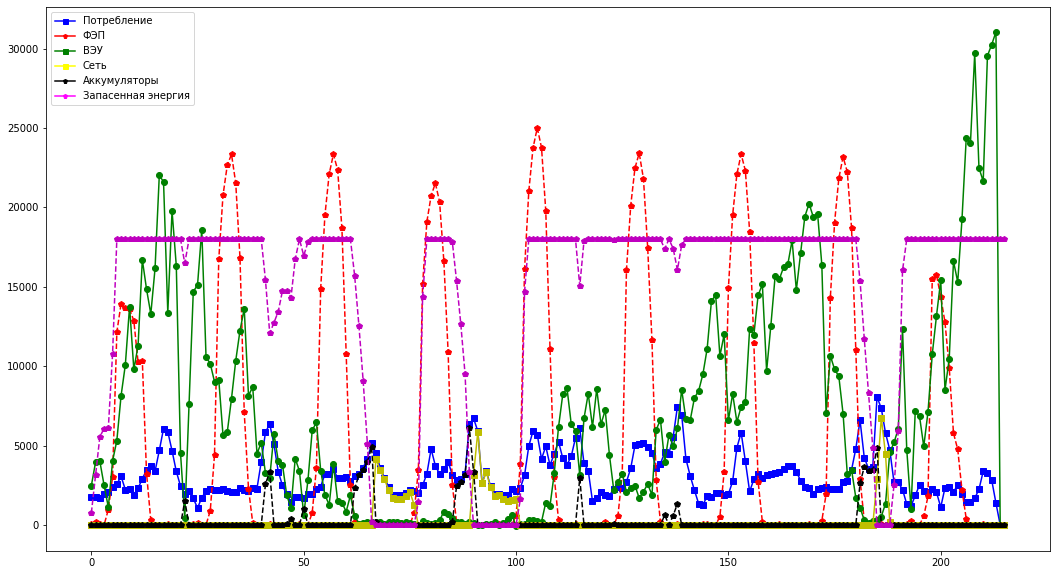

In [32]:
plt.figure(figsize=(18,10))
plt.plot(results['Demand'], 'b-s')
plt.plot(results['Solar'], 'r--p')
plt.plot(results['Wind'], 'g-o')
plt.plot(results['Grid'], 'y-s')
plt.plot(results['Storage'], 'k--p')
plt.plot(results['Stored Energy'], 'm--p')

blue_line = mlines.Line2D([], [], color='blue', marker='s',
                          markersize=5, label='Потребление')
red_line = mlines.Line2D([], [], color='red', marker='p',
                          markersize=5, label='ФЭП')
green_line = mlines.Line2D([], [], color='green', marker='s',
                          markersize=5, label='ВЭУ')
yellow_line = mlines.Line2D([], [], color='yellow', marker='s',
                          markersize=5, label='Сеть')
black_line = mlines.Line2D([], [], color='black', marker='p',
                          markersize=5, label='Аккумуляторы')
magenta_line = mlines.Line2D([], [], color='magenta', marker='p',
                          markersize=5, label='Запасенная энергия')

plt.legend(handles=[blue_line, red_line, green_line, yellow_line, black_line, magenta_line])